# BEETLE2

This is the Python Notebook with the project code, so the results can be viewed :)

In [ ]:
!pip install pydot
!pip install tensorflow
!pip install git+https://github.com/tensorflow/docs
!pip install keras

In [1]:
import csv
import pydot
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.svm import LinearSVR
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_docs as tfdocs
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow.compat.v2 as tf
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.constraints import maxnorm

#### Import the dataset
To train the Machine Learning models

In [2]:
dataset = pd.read_csv('datasets/Processed-Population-Data.csv')

Select the columns from the dataset that represent each material

In [3]:
# Basic Inputs - for all materials
basic_inputs = dataset.iloc[:,0:13]

# STEEL FRAME inputs
steel_inputs = dataset.iloc[:,15:23] 
steel_outputs = dataset.iloc[:,14:15]

# CONCRETE FRAME inputs
concrete_inputs = dataset.iloc[:,29:35]
concrete_outputs = dataset.iloc[:,23:26]

# GLULAM FRAME inputs
glulam_inputs = dataset.iloc[:, lambda dataset: [38, 40, 41, 42, 43]]
glulam_outputs = dataset.iloc[:, lambda dataset: [35, 36, 37, 39]]


KFold is used for cross validation. Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default). Each fold is then used once as a validation while the k - 1 remaining folds form the training set.

In [4]:
kf = KFold(n_splits = 5)
plt.style.use('ggplot')

### Utility functions

Splits the given dataset inputs (different inputs for different materials) into training and testing sets. 

StandardScaler scales and translates each feature individually. More info [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

In [5]:
def split_datasets(chosen_inputs, chosen_outputs):
    
    concatenated = pd.concat([basic_inputs, chosen_inputs], axis=1)
    X_traintest_concat, X_validation_concat, y_traintest_concat, y_validation_concat = train_test_split(concatenated, chosen_outputs, test_size = 0.2)
    X_train_concat, X_test_concat, y_train_concat, y_test_concat = train_test_split(X_traintest_concat, y_traintest_concat, test_size = 0.2)
    
    X_train_scaled = StandardScaler().fit_transform(X_train_concat)
    X_test_scaled = StandardScaler().fit_transform(X_test_concat)
    X_validation_scaled = StandardScaler().fit_transform(X_validation_concat)
    
    with_derived = [X_train_scaled, y_train_concat, X_test_scaled, y_test_concat, X_validation_scaled, y_validation_concat]
    print('Validation:\t', X_validation_scaled.shape, y_validation_concat.shape, '\n',
      'Training:  \t', X_train_scaled.shape, y_train_concat.shape, '\t Concatenated sets\n', 
      'Testing:   \t', X_test_scaled.shape, y_test_concat.shape, '\n')
    
    X_traintest, X_validation, y_traintest, y_validation = train_test_split(basic_inputs, chosen_outputs, test_size = 0.2)
    X_train, X_test, y_train, y_test = train_test_split(X_traintest, y_traintest, test_size = 0.2)
    
    X_train_scaled = StandardScaler().fit_transform(X_train)
    X_test_scaled = StandardScaler().fit_transform(X_test)
    X_validation_scaled = StandardScaler().fit_transform(X_validation)
    
    without = [X_train_scaled, y_train, X_test_scaled, y_test, X_validation_scaled, y_validation]
    print('Validation \t', X_validation_scaled.shape, y_validation.shape, '\n',
      'Training:  \t', X_train_scaled.shape, y_train.shape, '\t Without derived inputs sets\n',
      'Testing:   \t', X_test_scaled.shape, y_test.shape)
    
    return with_derived, without, concatenated.columns

The function below will plot a graph of true vs predicted values along with a line of what the perfect machine learning model should look like (predicting the exact, true values).

In [6]:
def visualizePredictionsVsActual(y_true, y_pred, title):
    plt.figure(figsize=(8,6))
    plt.scatter(y_true, y_pred, c='#FF7AA6') #A06CD5
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(title)
    ident = [0, max(y_true)]
    plt.plot(ident,ident, '--', c='#A06CD5')
    plt.show()

In [7]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

### RANDOM FOREST

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the ```max_samples``` parameter if ```bootstrap=True``` (default), otherwise the whole dataset is used to build each tree. More info [here](https://scikit-learn.org/stable/modules/ensemble.html#forest).

In [8]:
class RandomForest:
    def __init__(self, Xtrain, ytrain, Xtest, ytest, column_names):
        
        rf = RandomForestRegressor().fit(Xtrain, np.ravel(ytrain))
        
        self.model = rf
        self.feature_list = column_names
        
        self.predictions = rf.predict(Xtest)
        self.errors = abs(self.predictions - ytest.values) 
        self.mse = mean_squared_error(ytest.values.flatten(), self.predictions)
        self.mae = mean_absolute_error(ytest.values.flatten(), self.predictions)
        self.mape = np.mean(100 * (self.errors / ytest.values.flatten()))
        
        print('Random forest model: \t{}MAE: {:10.3f} \tMSE: {:10.3f} \tMAPE: {:10.3f}{}'.format(color.PURPLE, self.mae, self.mse, self.mape, color.END))
    
    def getImportances(self):
        print('-------------------VARIABLE IMPORTANCE--------------------')
        importances = list(self.model.feature_importances_)
        feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(self.feature_list, importances)]
        feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
        [print('{:50s} {:7.2f}'.format(*pair)) for pair in feature_importances]
        print('-'*58)
        return feature_importances
    
    def makeTree(self):
        tree = self.model.estimators_[5]
        export_graphviz(tree, out_file = 'images/tree.dot', feature_names = self.feature_list, rounded = True, precision = 1)
        (graph, ) = pydot.graph_from_dot_file('images/tree.dot')
        graph.write_png('images/tree.png')
        rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
        rf_small.fit(self.inputs_train, np.ravel(self.output_train))
        tree_small = rf_small.estimators_[5]
        export_graphviz(tree_small, out_file = 'images/small_tree.dot', feature_names = self.feature_list, rounded = True, precision = 1)
        (graph, ) = pydot.graph_from_dot_file('images/small_tree.dot')
        graph.write_png('images/small_tree.png')

In [9]:
def run_rf(chosen_inputs, chosen_outputs):
    
    print(f'Predicting {chosen_outputs.shape[1]} values.')
    
    for column in chosen_outputs:
        print('\n',color.BOLD + color.UNDERLINE + color.RED + column.upper() + color.END)
        with_derived, without, column_names = split_datasets(chosen_inputs, chosen_outputs[column])

        print('\n', color.BOLD + 'WITH DERIVED INPUTS' + color.END)
        rf = RandomForest(with_derived[0], with_derived[1], with_derived[2], with_derived[3], column_names)
        rf.getImportances()
        y_pred = rf.model.predict(with_derived[4])
        visualizePredictionsVsActual(with_derived[5], y_pred, 'Predicting '+column+' using RF and derived inputs')

        print(color.BOLD + 'WITHOUT DERIVED INPUTS' + color.END)
        rf = RandomForest(without[0], without[1], without[2], without[3], basic_inputs.columns)
        rf.getImportances()
        y_pred = rf.model.predict(without[4])
        visualizePredictionsVsActual(without[5], y_pred, 'Predicting '+column+' using RF without derived inputs')

### SUPPORT VECTOR REGRESSOR

Linear Support Vector Regression.

Similar to SVR with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples. More info [here](https://scikit-learn.org/stable/modules/svm.html#svm-regression).

In [10]:
class SVR:
    def __init__(self, Xtrain, ytrain, Xtest, ytest):
        
        self.model = LinearSVR().fit(Xtrain, np.ravel(ytrain))
        self.predictions = self.model.predict(Xtest)
        self.errors = abs(self.predictions - ytest) 
        self.mse = mean_squared_error(ytest, self.predictions)
        self.mae = mean_absolute_error(ytest, self.predictions)
        self.mape = np.mean(100 * (self.errors / ytest))
        
        print('SVR model: {}\t\tMAE: {:10.3f} \tMSE: {:10.3f} \tMAPE: {:10.3f}{}'.format(color.PURPLE, self.mae, self.mse, self.mape, color.END))

In [11]:
def run_svr(chosen_inputs, chosen_outputs):
    
    print(f'Predicting {chosen_outputs.shape[1]} values.')
    
    for column in chosen_outputs:
        print('\n',color.BOLD + color.UNDERLINE + color.RED + column.upper() + color.END)
        with_derived, without, _ = split_datasets(chosen_inputs, chosen_outputs[column])

        print('\n',color.BOLD + 'WITH DERIVED INPUTS' + color.END)
        svr = SVR(with_derived[0], with_derived[1], with_derived[2], with_derived[3].values.flatten())
        y_pred = svr.model.predict(with_derived[4])
        visualizePredictionsVsActual(with_derived[5], y_pred, 'Predicting using SVR and derived inputs')

        print(color.BOLD + 'WITHOUT DERIVED INPUTS' + color.END)
        svr = SVR(without[0], without[1], without[2], without[3].values.flatten())
        y_pred = svr.model.predict(without[4])
        visualizePredictionsVsActual(without[5], y_pred, 'Predicting '+column+' using SVR without derived inputs')

### ARTIFICIAL NEURAL NETWORK

In [12]:
class ANN:
    def __init__(self, Xtrain, ytrain, Xtest, ytest):
        
        model = Sequential()
        model.add(Dense(30, input_dim=Xtrain.shape[1], kernel_initializer='he_uniform', activation='relu'))
        model.add(Dropout(rate=0.3))
        model.add(Dense(1, kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer='adam', metrics=[tf.keras.metrics.MeanSquaredError()])
        model.fit(Xtrain, ytrain, verbose=0, epochs=100)
        
        self.model = model
        self.predictions = model.predict(Xtest)
        self.mse = mean_squared_error(ytest, self.predictions)
        self.mae = mean_absolute_error(ytest, self.predictions)
        
        errors = np.absolute(np.array(self.predictions).flatten() - np.array(ytest))
        self.mape = np.mean(100 * (errors / ytest))
        
        print('ANN model: \t{}MAE: {:10.3f} \tMSE: {:10.3f} \tMAPE: {:10.3f}{}'.format(color.PURPLE, self.mae, self.mse, self.mape, color.END))
        
    def visualizeNeuralNetwork(self):
        plot_model(self.model,
           show_shapes=True,
           show_layer_names=True,
           rankdir='TB',
           expand_nested=True,
           dpi=96)

In [13]:
def run_ann(chosen_inputs, chosen_outputs):
    
    print(f'Predicting {chosen_outputs.shape[1]} values.')
    
    for column in chosen_outputs:
        print('\n',color.BOLD + color.UNDERLINE + color.RED + column.upper() + color.END)
        with_derived, without, _ = split_datasets(chosen_inputs, chosen_outputs[column])

        print('\n',color.BOLD + 'WITH DERIVED INPUTS' + color.END)
        ann = ANN(with_derived[0], with_derived[1], with_derived[2], with_derived[3])
        y_pred = ann.model.predict(with_derived[4])
        visualizePredictionsVsActual(with_derived[5].values, y_pred, 'Predicting using ANN and derived inputs')

        print(color.BOLD + 'WITHOUT DERIVED INPUTS' + color.END)
        ann = ANN(without[0], without[1], without[2], without[3])
        y_pred = ann.model.predict(without[4])
        visualizePredictionsVsActual(without[5], y_pred, 'Predicting '+column+' using ANN without derived inputs')

# Predicting for Steel

We are going to make predictions with 2 different data sets, using the basic inputs that all materials share, and using the concatenated basic inputs with each derived material input. This will allow us to see if less variables can be used to make predictions and compare how efficient they are.

###### Random Forest for Steel

The Random Forest algorithm also prints the importance of each variable when making the predictions. 

Predicting 1 values.

 TOTAL MASS (RATIONALISED) STRUCTURAL STEEL FRAME
Validation:	 (2096, 21) (2096,) 
 Training:  	 (6704, 21) (6704,) 	 Concatenated sets
 Testing:   	 (1676, 21) (1676,) 

Validation 	 (2096, 13) (2096,) 
 Training:  	 (6704, 13) (6704,) 	 Without derived inputs sets
 Testing:   	 (1676, 13) (1676,)

 WITH DERIVED INPUTS
Random forest model: 	MAE:     64.508 	MSE:   9435.280 	MAPE:      6.004
-------------------VARIABLE IMPORTANCE--------------------
Total (concrete) mass of composite floor deck         0.86
Span Length along y dir.                              0.10
Total (steel) mass of composite floor deck            0.01
Footprint Area                                        0.00
Footprint Aspect Ratio                                0.00
Span Length along x dir.                              0.00
No of spans along x dir.                              0.00
No of spans along y dir.                              0.00
No of floors                                        

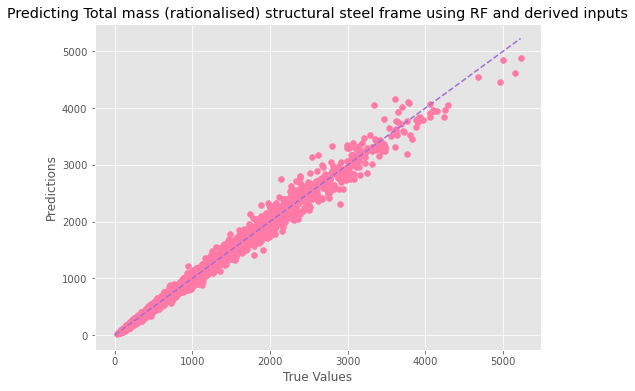

WITHOUT DERIVED INPUTS
Random forest model: 	MAE:     77.536 	MSE:  12889.920 	MAPE:      8.546
-------------------VARIABLE IMPORTANCE--------------------
No of floors                                          0.59
Footprint Area                                        0.27
Span Length along y dir.                              0.10
Weight of floor finisches                             0.01
Variable floor load                                   0.01
Footprint Aspect Ratio                                0.00
Span Length along x dir.                              0.00
No of spans along x dir.                              0.00
No of spans along y dir.                              0.00
Interstory heigh                                      0.00
Maximum spacing between secondary beamsa              0.00
Selfweight of composite floor deckb                   0.00
Weigth of envelope                                    0.00
----------------------------------------------------------


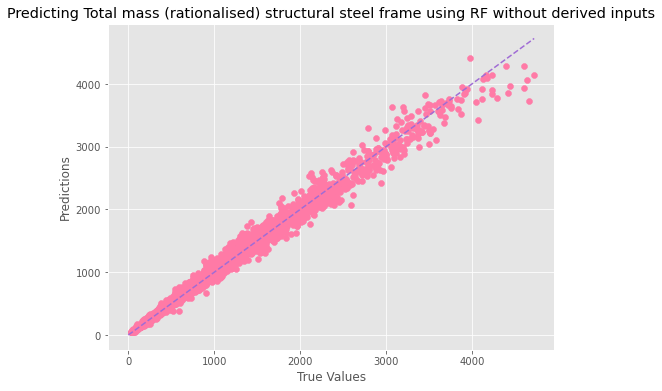

In [14]:
run_rf(steel_inputs, steel_outputs)

###### Support Vector Regressor for Steel

Predicting 1 values.

 TOTAL MASS (RATIONALISED) STRUCTURAL STEEL FRAME
Validation:	 (2096, 21) (2096,) 
 Training:  	 (6704, 21) (6704,) 	 Concatenated sets
 Testing:   	 (1676, 21) (1676,) 

Validation 	 (2096, 13) (2096,) 
 Training:  	 (6704, 13) (6704,) 	 Without derived inputs sets
 Testing:   	 (1676, 13) (1676,)

 WITH DERIVED INPUTS
SVR model: 		MAE:    119.231 	MSE:  34940.524 	MAPE:     21.517


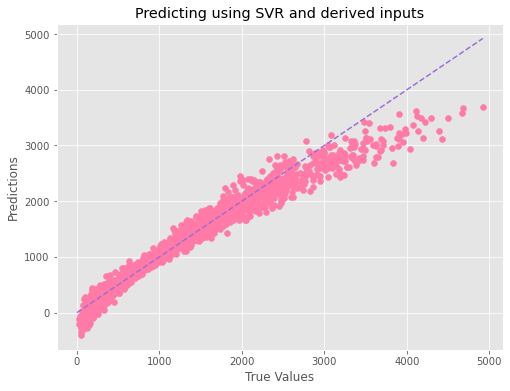

WITHOUT DERIVED INPUTS
SVR model: 		MAE:    236.330 	MSE: 129435.420 	MAPE:     47.499


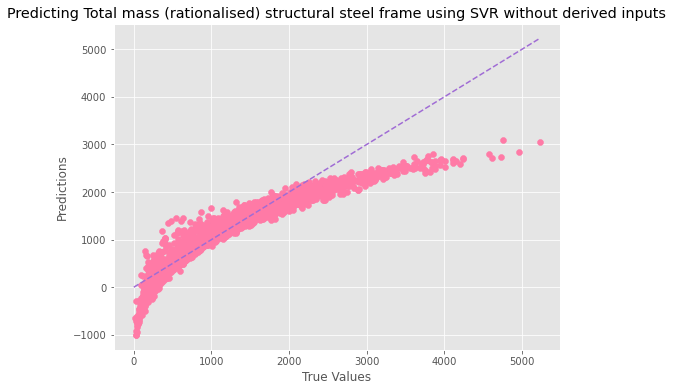

In [15]:
run_svr(steel_inputs, steel_outputs)

###### Artificial Neural Network for Steel

Predicting 1 values.

 TOTAL MASS (RATIONALISED) STRUCTURAL STEEL FRAME
Validation:	 (2096, 21) (2096,) 
 Training:  	 (6704, 21) (6704,) 	 Concatenated sets
 Testing:   	 (1676, 21) (1676,) 

Validation 	 (2096, 13) (2096,) 
 Training:  	 (6704, 13) (6704,) 	 Without derived inputs sets
 Testing:   	 (1676, 13) (1676,)

 WITH DERIVED INPUTS
ANN model: 	MAE:     96.772 	MSE:  17809.661 	MAPE:     14.224


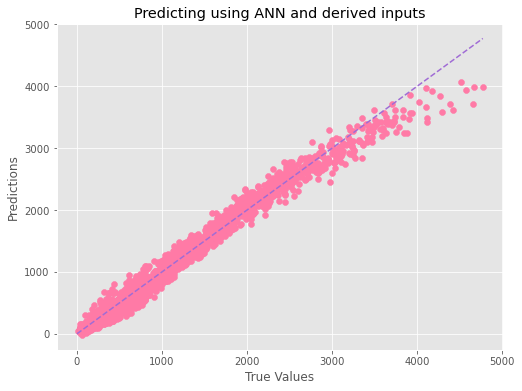

WITHOUT DERIVED INPUTS
ANN model: 	MAE:    145.794 	MSE:  37999.435 	MAPE:     22.734


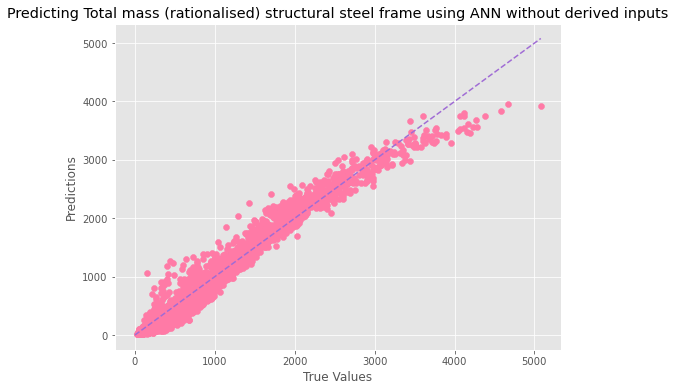

In [16]:
run_ann(steel_inputs, steel_outputs)

# Predicting for Reinforced Concrete

###### Random Forest for Reinforced Concrete

Predicting 3 values.

 TOTAL MASS (OPTIMISED) COLUMNS
Validation:	 (2096, 19) (2096,) 
 Training:  	 (6704, 19) (6704,) 	 Concatenated sets
 Testing:   	 (1676, 19) (1676,) 

Validation 	 (2096, 13) (2096,) 
 Training:  	 (6704, 13) (6704,) 	 Without derived inputs sets
 Testing:   	 (1676, 13) (1676,)

 WITH DERIVED INPUTS
Random forest model: 	MAE:     12.703 	MSE:    453.201 	MAPE:      5.537
-------------------VARIABLE IMPORTANCE--------------------
Total formwork surface area (columns)                 0.83
Total formwork surface area (floor slabs)g            0.12
No of floors                                          0.02
Span Length along y dir.                              0.01
Footprint Area                                        0.00
Footprint Aspect Ratio                                0.00
Span Length along x dir.                              0.00
No of spans along x dir.                              0.00
No of spans along y dir.                              0.00
Interstory 

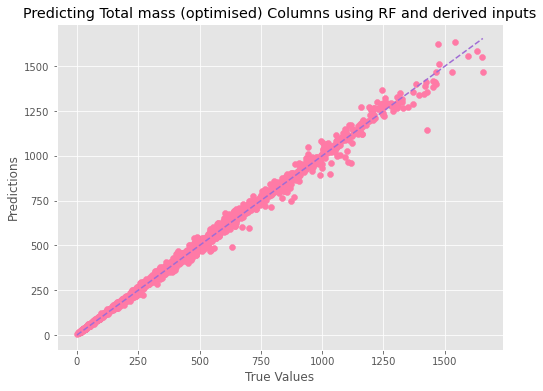

WITHOUT DERIVED INPUTS
Random forest model: 	MAE:     12.324 	MSE:    459.647 	MAPE:      3.593
-------------------VARIABLE IMPORTANCE--------------------
No of floors                                          0.75
Footprint Area                                        0.23
Span Length along y dir.                              0.02
Footprint Aspect Ratio                                0.00
Span Length along x dir.                              0.00
No of spans along x dir.                              0.00
No of spans along y dir.                              0.00
Interstory heigh                                      0.00
Maximum spacing between secondary beamsa              0.00
Selfweight of composite floor deckb                   0.00
Weight of floor finisches                             0.00
Variable floor load                                   0.00
Weigth of envelope                                    0.00
----------------------------------------------------------


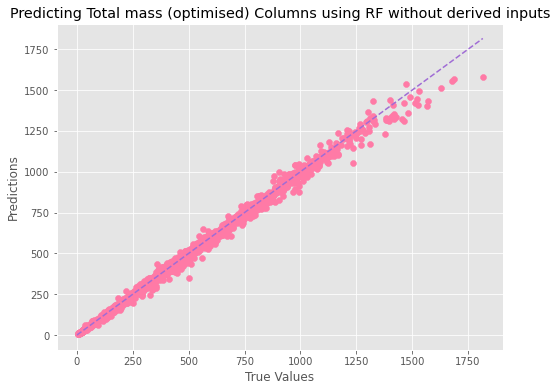


 TOTAL MASS (RATIONALISED) COLUMNS
Validation:	 (2096, 19) (2096,) 
 Training:  	 (6704, 19) (6704,) 	 Concatenated sets
 Testing:   	 (1676, 19) (1676,) 

Validation 	 (2096, 13) (2096,) 
 Training:  	 (6704, 13) (6704,) 	 Without derived inputs sets
 Testing:   	 (1676, 13) (1676,)

 WITH DERIVED INPUTS
Random forest model: 	MAE:     22.691 	MSE:   1763.923 	MAPE:      4.119
-------------------VARIABLE IMPORTANCE--------------------
Total formwork surface area (columns)                 0.81
Total formwork surface area (floor slabs)g            0.13
No of floors                                          0.03
Span Length along y dir.                              0.01
Footprint Area                                        0.00
Footprint Aspect Ratio                                0.00
Span Length along x dir.                              0.00
No of spans along x dir.                              0.00
No of spans along y dir.                              0.00
Interstory heigh             

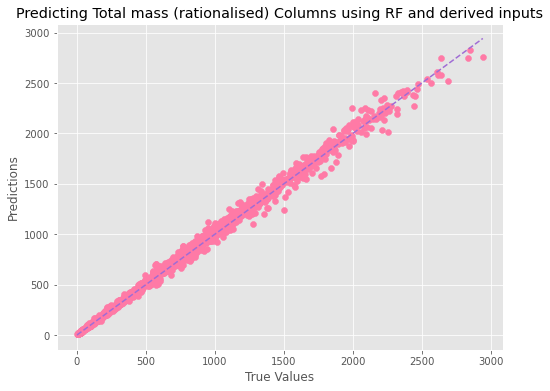

WITHOUT DERIVED INPUTS
Random forest model: 	MAE:     19.754 	MSE:   1353.821 	MAPE:      3.849
-------------------VARIABLE IMPORTANCE--------------------
No of floors                                          0.75
Footprint Area                                        0.22
Span Length along y dir.                              0.02
Footprint Aspect Ratio                                0.00
Span Length along x dir.                              0.00
No of spans along x dir.                              0.00
No of spans along y dir.                              0.00
Interstory heigh                                      0.00
Maximum spacing between secondary beamsa              0.00
Selfweight of composite floor deckb                   0.00
Weight of floor finisches                             0.00
Variable floor load                                   0.00
Weigth of envelope                                    0.00
----------------------------------------------------------


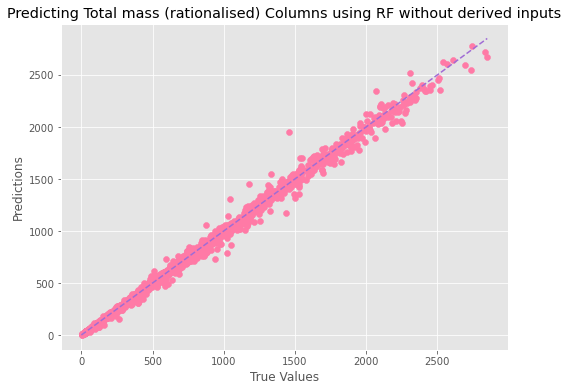


 TOTAL MASS CONCRETE FLOORS (BEAMS + SLABS)
Validation:	 (2096, 19) (2096,) 
 Training:  	 (6704, 19) (6704,) 	 Concatenated sets
 Testing:   	 (1676, 19) (1676,) 

Validation 	 (2096, 13) (2096,) 
 Training:  	 (6704, 13) (6704,) 	 Without derived inputs sets
 Testing:   	 (1676, 13) (1676,)

 WITH DERIVED INPUTS
Random forest model: 	MAE:    154.300 	MSE:  80299.993 	MAPE:      3.306
-------------------VARIABLE IMPORTANCE--------------------
Total formwork surface area (floor slabs)g            0.97
Span Length along y dir.                              0.03
Footprint Area                                        0.00
Footprint Aspect Ratio                                0.00
Span Length along x dir.                              0.00
No of spans along x dir.                              0.00
No of spans along y dir.                              0.00
No of floors                                          0.00
Interstory heigh                                      0.00
Maximum spacing betw

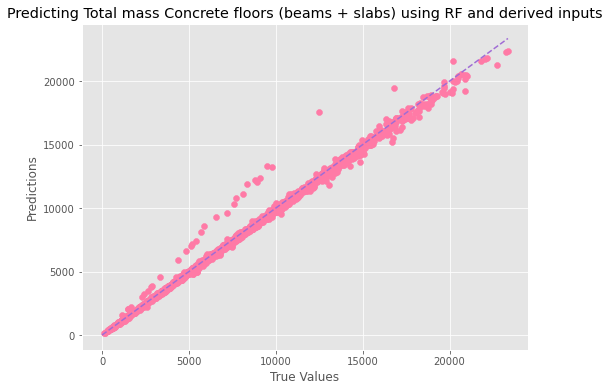

WITHOUT DERIVED INPUTS
Random forest model: 	MAE:    195.030 	MSE: 121189.698 	MAPE:      3.433
-------------------VARIABLE IMPORTANCE--------------------
No of floors                                          0.61
Footprint Area                                        0.35
Span Length along y dir.                              0.03
Footprint Aspect Ratio                                0.00
Span Length along x dir.                              0.00
No of spans along x dir.                              0.00
No of spans along y dir.                              0.00
Interstory heigh                                      0.00
Maximum spacing between secondary beamsa              0.00
Selfweight of composite floor deckb                   0.00
Weight of floor finisches                             0.00
Variable floor load                                   0.00
Weigth of envelope                                    0.00
----------------------------------------------------------


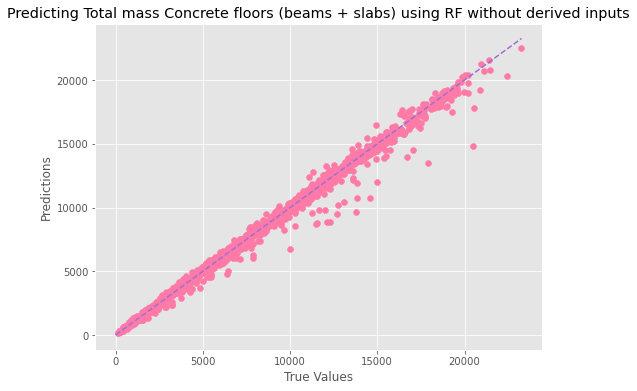

In [17]:
run_rf(concrete_inputs, concrete_outputs)

###### SVR for Reinforced Concrete

Predicting 3 values.

 TOTAL MASS (OPTIMISED) COLUMNS
Validation:	 (2096, 19) (2096,) 
 Training:  	 (6704, 19) (6704,) 	 Concatenated sets
 Testing:   	 (1676, 19) (1676,) 

Validation 	 (2096, 13) (2096,) 
 Training:  	 (6704, 13) (6704,) 	 Without derived inputs sets
 Testing:   	 (1676, 13) (1676,)

 WITH DERIVED INPUTS
SVR model: 		MAE:     22.883 	MSE:   1463.696 	MAPE:     20.850


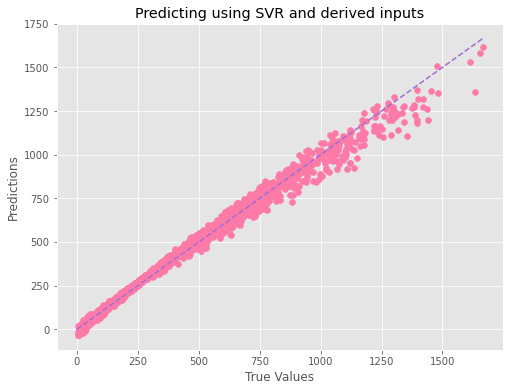

WITHOUT DERIVED INPUTS
SVR model: 		MAE:     95.477 	MSE:  20292.277 	MAPE:    121.579


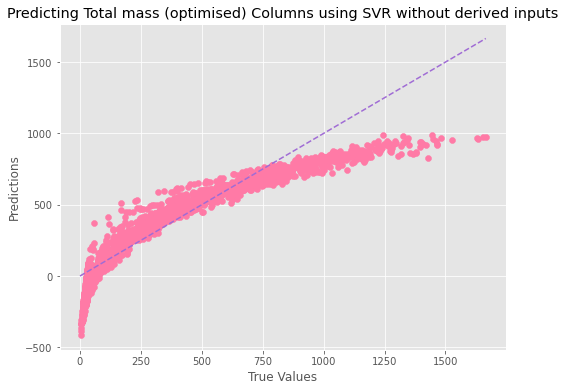


 TOTAL MASS (RATIONALISED) COLUMNS
Validation:	 (2096, 19) (2096,) 
 Training:  	 (6704, 19) (6704,) 	 Concatenated sets
 Testing:   	 (1676, 19) (1676,) 

Validation 	 (2096, 13) (2096,) 
 Training:  	 (6704, 13) (6704,) 	 Without derived inputs sets
 Testing:   	 (1676, 13) (1676,)

 WITH DERIVED INPUTS
SVR model: 		MAE:     65.141 	MSE:  10938.007 	MAPE:     57.468


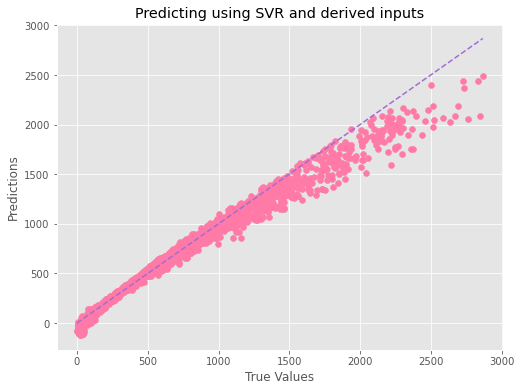

WITHOUT DERIVED INPUTS
SVR model: 		MAE:    174.621 	MSE:  74133.810 	MAPE:    198.432


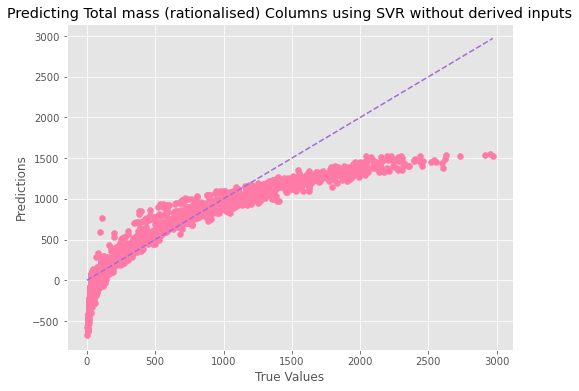


 TOTAL MASS CONCRETE FLOORS (BEAMS + SLABS)
Validation:	 (2096, 19) (2096,) 
 Training:  	 (6704, 19) (6704,) 	 Concatenated sets
 Testing:   	 (1676, 19) (1676,) 

Validation 	 (2096, 13) (2096,) 
 Training:  	 (6704, 13) (6704,) 	 Without derived inputs sets
 Testing:   	 (1676, 13) (1676,)

 WITH DERIVED INPUTS
SVR model: 		MAE:   1609.941 	MSE: 5300051.096 	MAPE:     20.897


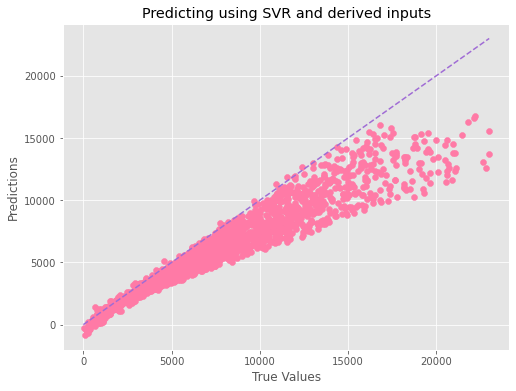

WITHOUT DERIVED INPUTS
SVR model: 		MAE:   2880.212 	MSE: 16082204.142 	MAPE:     37.084


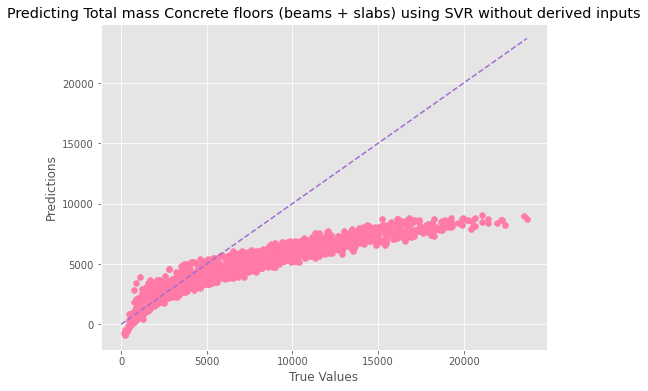

In [18]:
run_svr(concrete_inputs, concrete_outputs)

###### Artificial Neural Network for Reinforced Concrete

Predicting 3 values.

 TOTAL MASS (OPTIMISED) COLUMNS
Validation:	 (2096, 19) (2096,) 
 Training:  	 (6704, 19) (6704,) 	 Concatenated sets
 Testing:   	 (1676, 19) (1676,) 

Validation 	 (2096, 13) (2096,) 
 Training:  	 (6704, 13) (6704,) 	 Without derived inputs sets
 Testing:   	 (1676, 13) (1676,)

 WITH DERIVED INPUTS
ANN model: 	MAE:     28.448 	MSE:   1549.167 	MAPE:     14.878


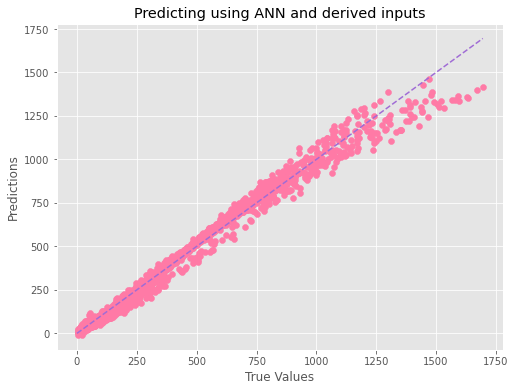

WITHOUT DERIVED INPUTS
ANN model: 	MAE:     37.541 	MSE:   2778.538 	MAPE:     18.663


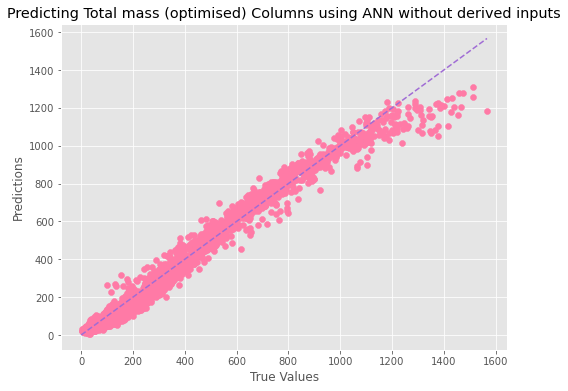


 TOTAL MASS (RATIONALISED) COLUMNS
Validation:	 (2096, 19) (2096,) 
 Training:  	 (6704, 19) (6704,) 	 Concatenated sets
 Testing:   	 (1676, 19) (1676,) 

Validation 	 (2096, 13) (2096,) 
 Training:  	 (6704, 13) (6704,) 	 Without derived inputs sets
 Testing:   	 (1676, 13) (1676,)

 WITH DERIVED INPUTS
ANN model: 	MAE:     52.054 	MSE:   6303.280 	MAPE:     17.426


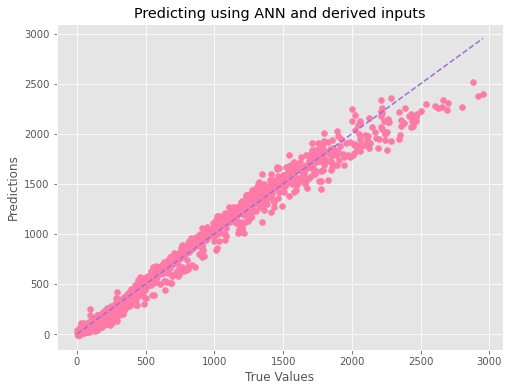

WITHOUT DERIVED INPUTS
ANN model: 	MAE:     71.658 	MSE:   9959.229 	MAPE:     25.321


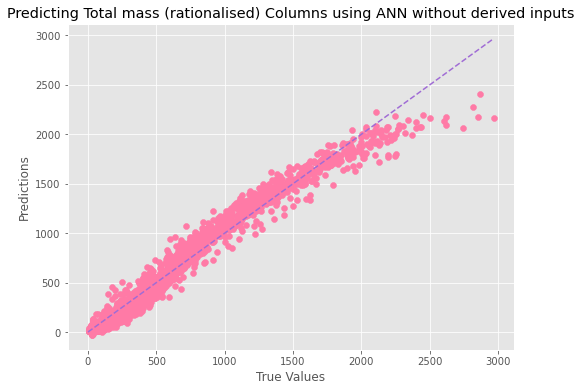


 TOTAL MASS CONCRETE FLOORS (BEAMS + SLABS)
Validation:	 (2096, 19) (2096,) 
 Training:  	 (6704, 19) (6704,) 	 Concatenated sets
 Testing:   	 (1676, 19) (1676,) 

Validation 	 (2096, 13) (2096,) 
 Training:  	 (6704, 13) (6704,) 	 Without derived inputs sets
 Testing:   	 (1676, 13) (1676,)

 WITH DERIVED INPUTS
ANN model: 	MAE:    930.843 	MSE: 1380146.958 	MAPE:     25.737


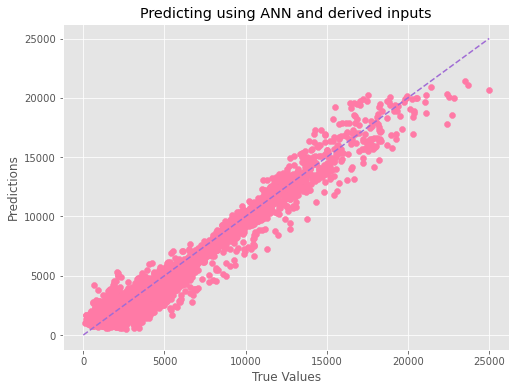

WITHOUT DERIVED INPUTS
ANN model: 	MAE:    920.759 	MSE: 1386349.116 	MAPE:     24.290


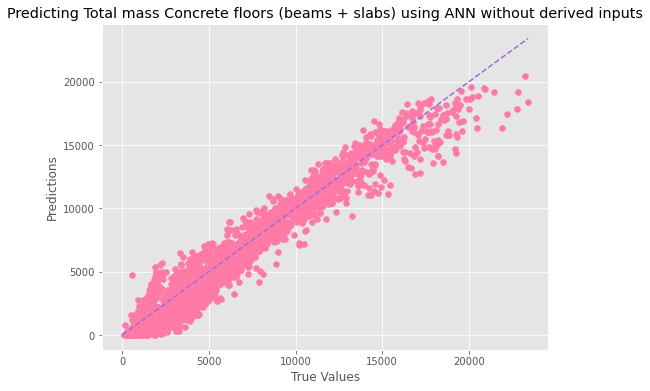

In [19]:
run_ann(concrete_inputs, concrete_outputs)

# Predicting for Glulam

###### Random Forest for Glulam

Predicting 4 values.

 TOTAL MASS (RATIONALISED) COLUMNS 2
Validation:	 (2096, 18) (2096,) 
 Training:  	 (6704, 18) (6704,) 	 Concatenated sets
 Testing:   	 (1676, 18) (1676,) 

Validation 	 (2096, 13) (2096,) 
 Training:  	 (6704, 13) (6704,) 	 Without derived inputs sets
 Testing:   	 (1676, 13) (1676,)

 WITH DERIVED INPUTS
Random forest model: 	MAE:      4.317 	MSE:     58.378 	MAPE:      5.014
-------------------VARIABLE IMPORTANCE--------------------
Total No of (CLT) slabsh                              0.73
No of floors                                          0.13
Variable floor load                                   0.08
Weight of floor finisches                             0.05
Footprint Area                                        0.00
Footprint Aspect Ratio                                0.00
Span Length along x dir.                              0.00
Span Length along y dir.                              0.00
No of spans along x dir.                              0.00
No of 

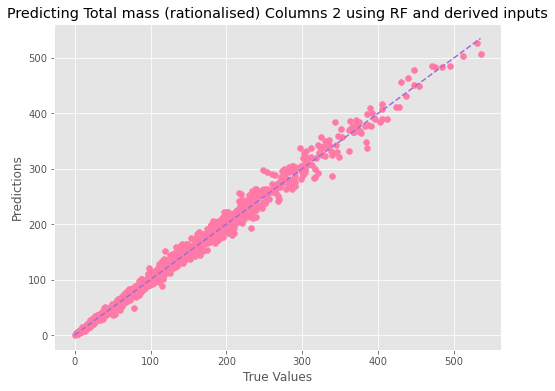

WITHOUT DERIVED INPUTS
Random forest model: 	MAE:      4.455 	MSE:     52.553 	MAPE:      5.357
-------------------VARIABLE IMPORTANCE--------------------
No of floors                                          0.69
Footprint Area                                        0.18
Variable floor load                                   0.07
Weight of floor finisches                             0.06
Footprint Aspect Ratio                                0.00
Span Length along x dir.                              0.00
Span Length along y dir.                              0.00
No of spans along x dir.                              0.00
No of spans along y dir.                              0.00
Interstory heigh                                      0.00
Maximum spacing between secondary beamsa              0.00
Selfweight of composite floor deckb                   0.00
Weigth of envelope                                    0.00
----------------------------------------------------------


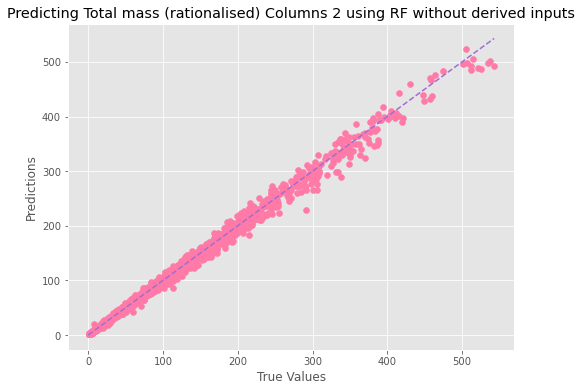


 TOTAL MASS TIMBER FLOORS (GLULAM BEAMS + CLT SLABS)
Validation:	 (2096, 18) (2096,) 
 Training:  	 (6704, 18) (6704,) 	 Concatenated sets
 Testing:   	 (1676, 18) (1676,) 

Validation 	 (2096, 13) (2096,) 
 Training:  	 (6704, 13) (6704,) 	 Without derived inputs sets
 Testing:   	 (1676, 13) (1676,)

 WITH DERIVED INPUTS
Random forest model: 	MAE:     30.933 	MSE:   2307.714 	MAPE:      2.354
-------------------VARIABLE IMPORTANCE--------------------
Total No of (CLT) slabsh                              0.98
Span Length along y dir.                              0.01
Footprint Area                                        0.00
Footprint Aspect Ratio                                0.00
Span Length along x dir.                              0.00
No of spans along x dir.                              0.00
No of spans along y dir.                              0.00
No of floors                                          0.00
Interstory heigh                                      0.00
Maximum spa

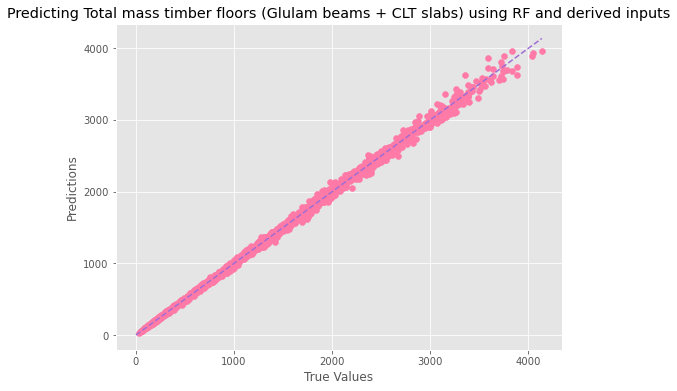

WITHOUT DERIVED INPUTS
Random forest model: 	MAE:     36.613 	MSE:   2921.939 	MAPE:      3.265
-------------------VARIABLE IMPORTANCE--------------------
No of floors                                          0.62
Footprint Area                                        0.36
Span Length along y dir.                              0.01
Footprint Aspect Ratio                                0.00
Span Length along x dir.                              0.00
No of spans along x dir.                              0.00
No of spans along y dir.                              0.00
Interstory heigh                                      0.00
Maximum spacing between secondary beamsa              0.00
Selfweight of composite floor deckb                   0.00
Weight of floor finisches                             0.00
Variable floor load                                   0.00
Weigth of envelope                                    0.00
----------------------------------------------------------


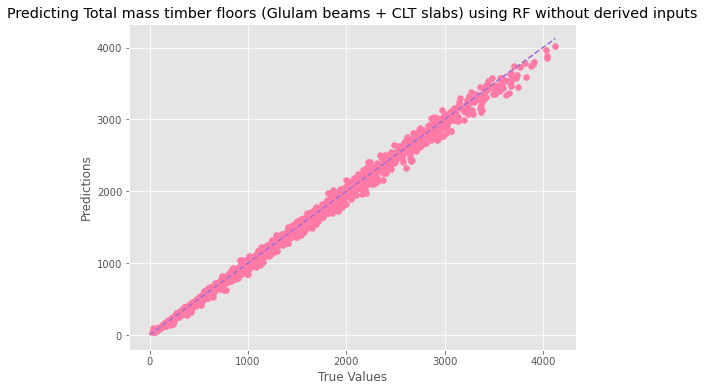


 TOTAL MASS (RATIONALISED) TIMBER  FRAME
Validation:	 (2096, 18) (2096,) 
 Training:  	 (6704, 18) (6704,) 	 Concatenated sets
 Testing:   	 (1676, 18) (1676,) 

Validation 	 (2096, 13) (2096,) 
 Training:  	 (6704, 13) (6704,) 	 Without derived inputs sets
 Testing:   	 (1676, 13) (1676,)

 WITH DERIVED INPUTS
Random forest model: 	MAE:     36.100 	MSE:   3117.720 	MAPE:      2.732
-------------------VARIABLE IMPORTANCE--------------------
Total No of (CLT) slabsh                              0.98
Weight of floor finisches                             0.01
Variable floor load                                   0.01
Footprint Area                                        0.00
Footprint Aspect Ratio                                0.00
Span Length along x dir.                              0.00
Span Length along y dir.                              0.00
No of spans along x dir.                              0.00
No of spans along y dir.                              0.00
No of floors           

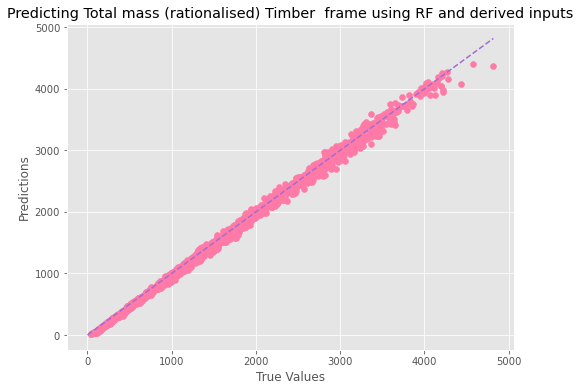

WITHOUT DERIVED INPUTS
Random forest model: 	MAE:     38.733 	MSE:   3347.450 	MAPE:      3.092
-------------------VARIABLE IMPORTANCE--------------------
No of floors                                          0.63
Footprint Area                                        0.35
Span Length along y dir.                              0.01
Weight of floor finisches                             0.01
Variable floor load                                   0.01
Footprint Aspect Ratio                                0.00
Span Length along x dir.                              0.00
No of spans along x dir.                              0.00
No of spans along y dir.                              0.00
Interstory heigh                                      0.00
Maximum spacing between secondary beamsa              0.00
Selfweight of composite floor deckb                   0.00
Weigth of envelope                                    0.00
----------------------------------------------------------


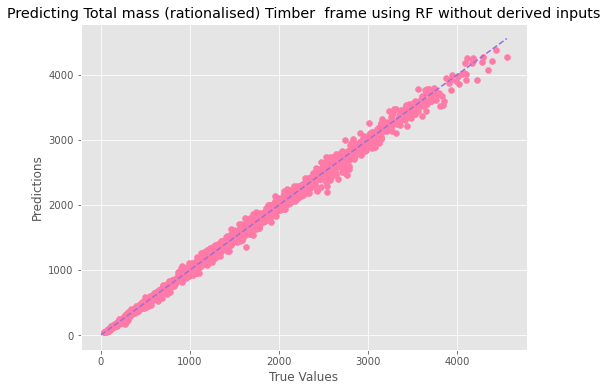


 TOTAL MASS (RATIONALISED) COLUMNS PLUS BEAMS
Validation:	 (2096, 18) (2096,) 
 Training:  	 (6704, 18) (6704,) 	 Concatenated sets
 Testing:   	 (1676, 18) (1676,) 

Validation 	 (2096, 13) (2096,) 
 Training:  	 (6704, 13) (6704,) 	 Without derived inputs sets
 Testing:   	 (1676, 13) (1676,)

 WITH DERIVED INPUTS
Random forest model: 	MAE:     25.280 	MSE:   1466.186 	MAPE:      4.745
-------------------VARIABLE IMPORTANCE--------------------
Total No of (CLT) slabsh                              0.90
Span Length along y dir.                              0.03
Weight of floor finisches                             0.03
Variable floor load                                   0.03
Footprint Area                                        0.00
Footprint Aspect Ratio                                0.00
Span Length along x dir.                              0.00
No of spans along x dir.                              0.00
No of spans along y dir.                              0.00
No of floors      

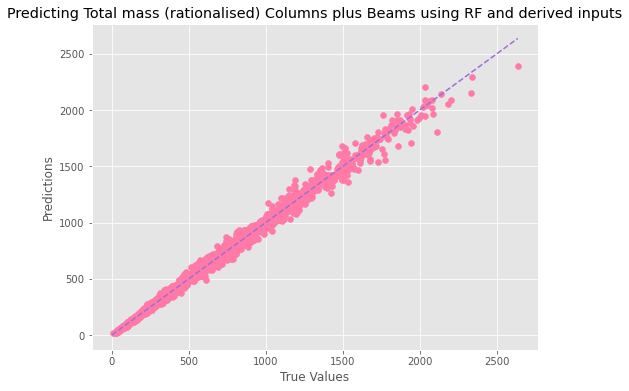

WITHOUT DERIVED INPUTS
Random forest model: 	MAE:     30.149 	MSE:   2090.418 	MAPE:      5.300
-------------------VARIABLE IMPORTANCE--------------------
No of floors                                          0.61
Footprint Area                                        0.29
Span Length along y dir.                              0.03
Weight of floor finisches                             0.03
Variable floor load                                   0.03
Span Length along x dir.                              0.01
Footprint Aspect Ratio                                0.00
No of spans along x dir.                              0.00
No of spans along y dir.                              0.00
Interstory heigh                                      0.00
Maximum spacing between secondary beamsa              0.00
Selfweight of composite floor deckb                   0.00
Weigth of envelope                                    0.00
----------------------------------------------------------


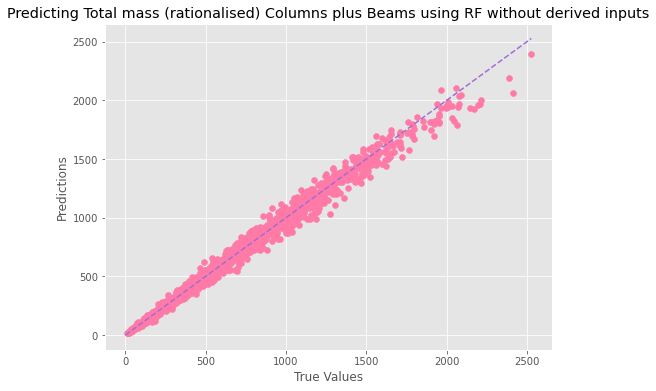

In [20]:
run_rf(glulam_inputs, glulam_outputs)

###### Support Vector Regression for Glulam

Predicting 4 values.

 TOTAL MASS (RATIONALISED) COLUMNS 2
Validation:	 (2096, 18) (2096,) 
 Training:  	 (6704, 18) (6704,) 	 Concatenated sets
 Testing:   	 (1676, 18) (1676,) 

Validation 	 (2096, 13) (2096,) 
 Training:  	 (6704, 13) (6704,) 	 Without derived inputs sets
 Testing:   	 (1676, 13) (1676,)

 WITH DERIVED INPUTS
SVR model: 		MAE:     21.725 	MSE:   1242.068 	MAPE:    128.178


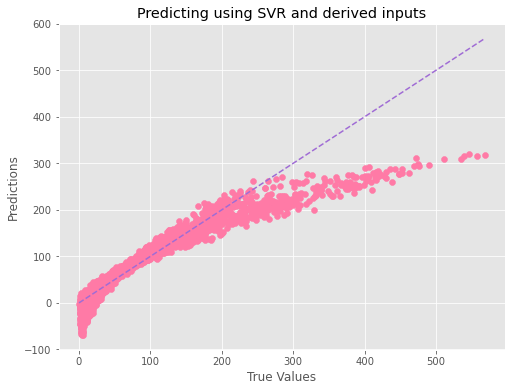

WITHOUT DERIVED INPUTS
SVR model: 		MAE:     28.442 	MSE:   2122.702 	MAPE:    185.745


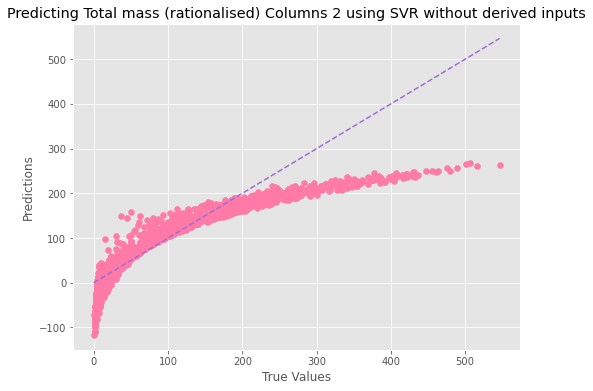


 TOTAL MASS TIMBER FLOORS (GLULAM BEAMS + CLT SLABS)
Validation:	 (2096, 18) (2096,) 
 Training:  	 (6704, 18) (6704,) 	 Concatenated sets
 Testing:   	 (1676, 18) (1676,) 

Validation 	 (2096, 13) (2096,) 
 Training:  	 (6704, 13) (6704,) 	 Without derived inputs sets
 Testing:   	 (1676, 13) (1676,)

 WITH DERIVED INPUTS
SVR model: 		MAE:     58.037 	MSE:   6976.590 	MAPE:     11.204


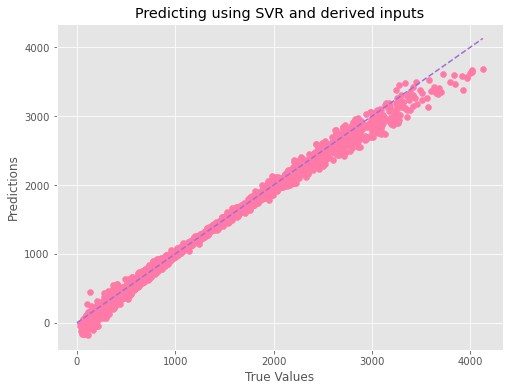

WITHOUT DERIVED INPUTS
SVR model: 		MAE:    197.649 	MSE:  75477.646 	MAPE:     46.805


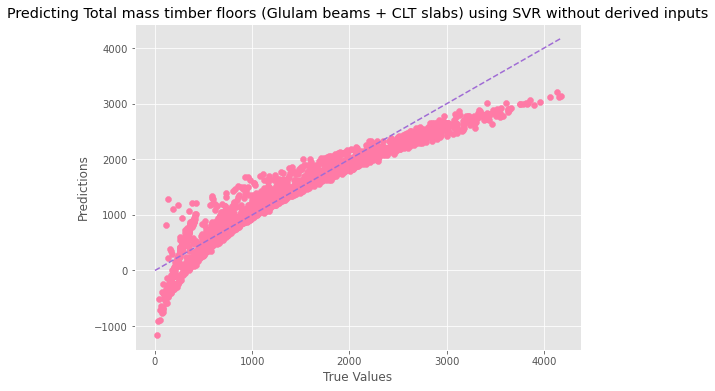


 TOTAL MASS (RATIONALISED) TIMBER  FRAME
Validation:	 (2096, 18) (2096,) 
 Training:  	 (6704, 18) (6704,) 	 Concatenated sets
 Testing:   	 (1676, 18) (1676,) 

Validation 	 (2096, 13) (2096,) 
 Training:  	 (6704, 13) (6704,) 	 Without derived inputs sets
 Testing:   	 (1676, 13) (1676,)

 WITH DERIVED INPUTS
SVR model: 		MAE:     75.829 	MSE:  12750.376 	MAPE:     12.949


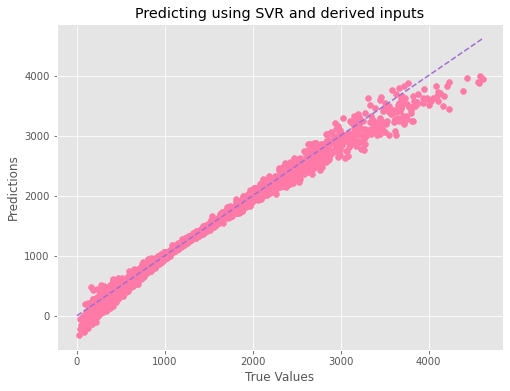

WITHOUT DERIVED INPUTS
SVR model: 		MAE:    226.565 	MSE: 101332.987 	MAPE:     47.840


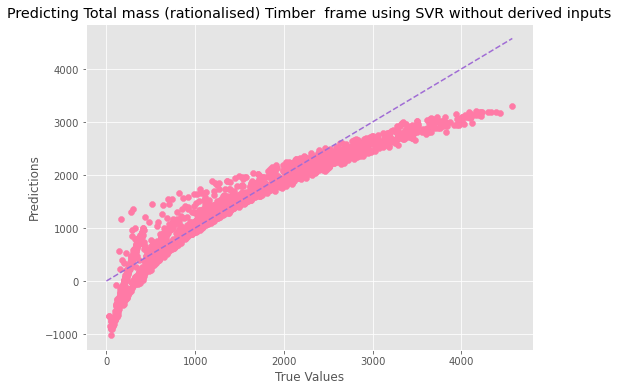


 TOTAL MASS (RATIONALISED) COLUMNS PLUS BEAMS
Validation:	 (2096, 18) (2096,) 
 Training:  	 (6704, 18) (6704,) 	 Concatenated sets
 Testing:   	 (1676, 18) (1676,) 

Validation 	 (2096, 13) (2096,) 
 Training:  	 (6704, 13) (6704,) 	 Without derived inputs sets
 Testing:   	 (1676, 13) (1676,)

 WITH DERIVED INPUTS
SVR model: 		MAE:     66.725 	MSE:  10748.150 	MAPE:     23.748


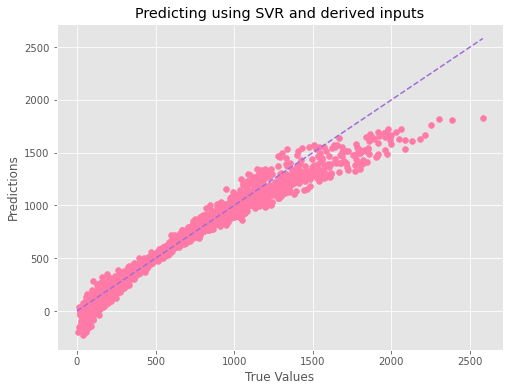

WITHOUT DERIVED INPUTS
SVR model: 		MAE:    105.656 	MSE:  24307.969 	MAPE:     53.906


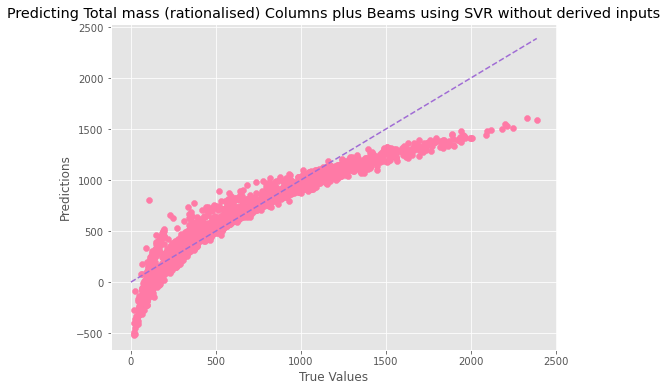

In [21]:
run_svr(glulam_inputs, glulam_outputs)

###### Artificial Neural Network for Glulam

Predicting 4 values.

 TOTAL MASS (RATIONALISED) COLUMNS 2
Validation:	 (2096, 18) (2096,) 
 Training:  	 (6704, 18) (6704,) 	 Concatenated sets
 Testing:   	 (1676, 18) (1676,) 

Validation 	 (2096, 13) (2096,) 
 Training:  	 (6704, 13) (6704,) 	 Without derived inputs sets
 Testing:   	 (1676, 13) (1676,)

 WITH DERIVED INPUTS
ANN model: 	MAE:      7.137 	MSE:    115.793 	MAPE:     22.576


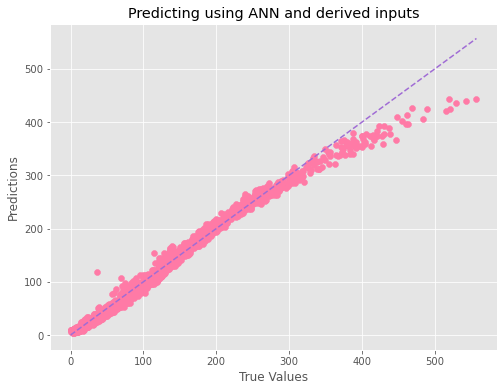

WITHOUT DERIVED INPUTS
ANN model: 	MAE:      7.769 	MSE:    134.667 	MAPE:     26.242


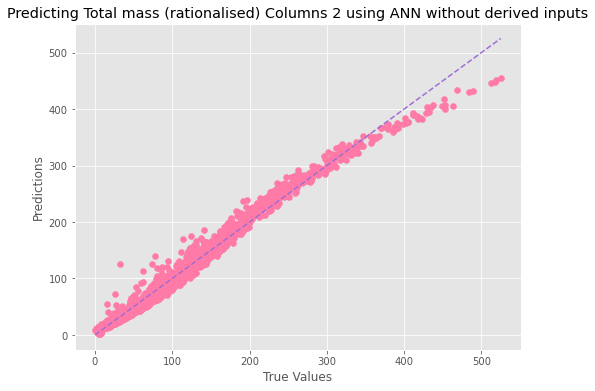


 TOTAL MASS TIMBER FLOORS (GLULAM BEAMS + CLT SLABS)
Validation:	 (2096, 18) (2096,) 
 Training:  	 (6704, 18) (6704,) 	 Concatenated sets
 Testing:   	 (1676, 18) (1676,) 

Validation 	 (2096, 13) (2096,) 
 Training:  	 (6704, 13) (6704,) 	 Without derived inputs sets
 Testing:   	 (1676, 13) (1676,)

 WITH DERIVED INPUTS
ANN model: 	MAE:     90.655 	MSE:  12575.690 	MAPE:     11.003


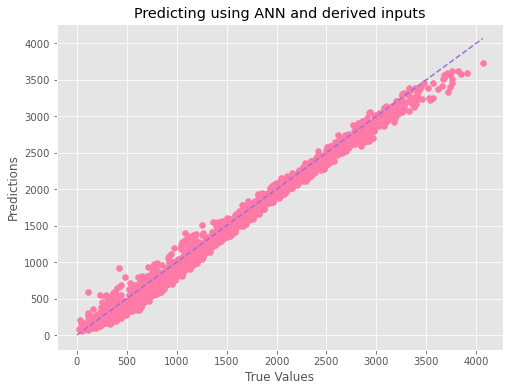

WITHOUT DERIVED INPUTS
ANN model: 	MAE:    135.480 	MSE:  28945.958 	MAPE:     19.056


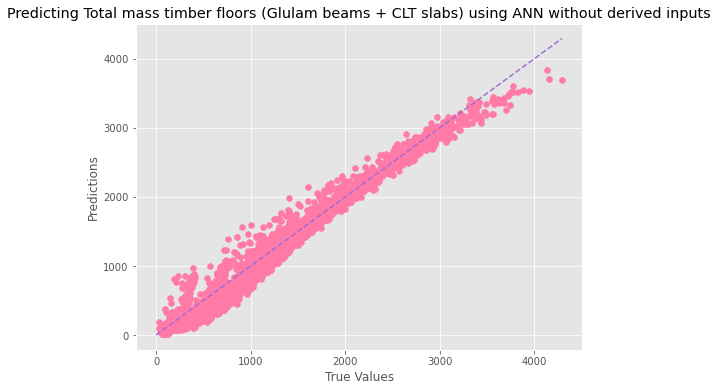


 TOTAL MASS (RATIONALISED) TIMBER  FRAME
Validation:	 (2096, 18) (2096,) 
 Training:  	 (6704, 18) (6704,) 	 Concatenated sets
 Testing:   	 (1676, 18) (1676,) 

Validation 	 (2096, 13) (2096,) 
 Training:  	 (6704, 13) (6704,) 	 Without derived inputs sets
 Testing:   	 (1676, 13) (1676,)

 WITH DERIVED INPUTS
ANN model: 	MAE:     87.421 	MSE:  12366.980 	MAPE:     12.737


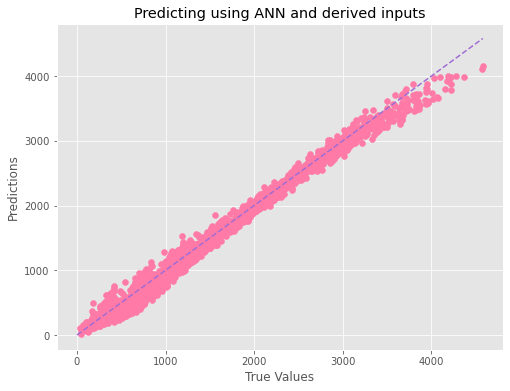

WITHOUT DERIVED INPUTS
ANN model: 	MAE:    134.997 	MSE:  30997.358 	MAPE:     18.384


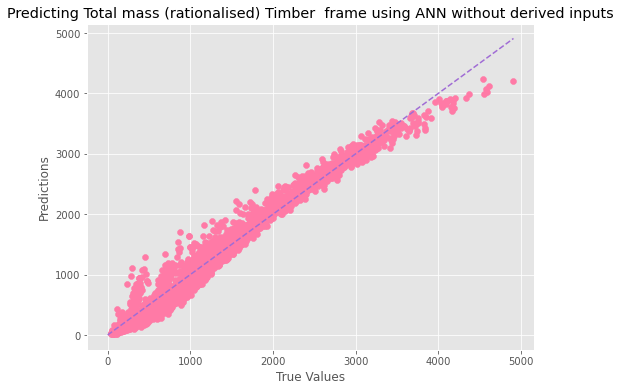


 TOTAL MASS (RATIONALISED) COLUMNS PLUS BEAMS
Validation:	 (2096, 18) (2096,) 
 Training:  	 (6704, 18) (6704,) 	 Concatenated sets
 Testing:   	 (1676, 18) (1676,) 

Validation 	 (2096, 13) (2096,) 
 Training:  	 (6704, 13) (6704,) 	 Without derived inputs sets
 Testing:   	 (1676, 13) (1676,)

 WITH DERIVED INPUTS
ANN model: 	MAE:     41.325 	MSE:   3407.074 	MAPE:     11.396


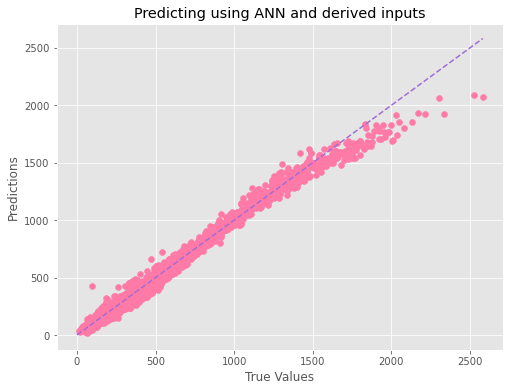

WITHOUT DERIVED INPUTS
ANN model: 	MAE:     64.264 	MSE:   7639.205 	MAPE:     18.837


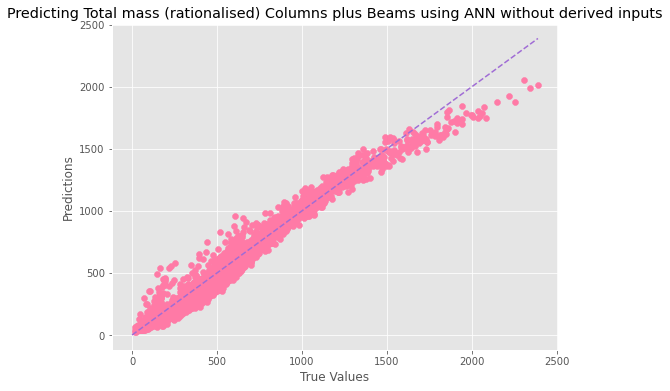

In [22]:
run_ann(glulam_inputs, glulam_outputs)

# Cross Validation

In [ ]:
#TODO: Fix this
# def evaluate_model(X, y, n_splits=10, model, epochs=100):
#     results = list()
#     cv = RepeatedKFold(n_splits=n_splits)
#     for train_ix, test_ix in cv.split(X):
#         X_train, X_test = X[train_ix], X[test_ix]
#         y_train, y_test = y[train_ix], y[test_ix]
# #         model = get_model(X.shape[1], y.shape[1])
#         model.fit(X_train, y_train, verbose=0, epochs=epochs)
#         mae = model.evaluate(X_test, y_test, verbose=0)
#         print('> %.3f' % mae)
#         results.append(mae)
#     return results

# Conclusions

- All the machine learning models perform better with derived inputs
- The machine learning model that performs best is Random Forest, then the Artificial Neural Network, and finally the Support Vector Regressor. 
- Still need to do grid search on the ANN. 